# Mobile Phone Usage Analysis (Oct–Nov 2025)

# 1. INTRODUCTION

In the past decade, the smartphone has quietly evolved from a simple communication device into a constant companion; an alarm clock, a camera, a map, a workspace, and often a source of distraction. We reach for it instinctively: to fill a moment, check a notification, or out of pure habit. Because of this, our phones have become accurate reflections of our daily routines.

What makes this especially interesting is that smartphones automatically record much of this behavior: how often we unlock them, which apps consume our attention, and how much time we spend scrolling, messaging, learning, or simply passing time. Hidden in these numbers is a story about habits, priorities, and digital well-being.

This project aims to explore that story by analyzing my personal smartphone usage between 29 September and 29 November 2025. Using a structured dataset and Python I will examine patterns in overall screen time, app usage, and how these habits evolve throughout the two-month period.

# 2. DATASET DESCRIPTION

The dataset, contained in `mobile_usage_oct_nov.csv`, holds daily records of my phone usage from 29/09/2025 to 29/11/2025. It includes the following features:

- date — the day of observation
- total_time — total daily screen time
- insta_mins — minutes spent on Instagram
- youtube_mins — minutes spent on YouTube
- whatsapp_mins — minutes spent on WhatsApp
- google_mins — minutes spent on Google Chrome
- duolingo_mins — minutes spent on Duolingo



**Note:**  
`total_time` is not the exact sum of the apps below, as we are only tracking the main apps I use daily (Instagram, Youtube, WhatsApp, Google Chrome, Duolingo).  



# 3. LOAD THE DATASET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Input file
INPUT_FILENAME = 'mobile_usage_oct_nov.csv'
df = pd.read_csv(INPUT_FILENAME, sep=';')

# Display the first rows
df.head()

,date,total_time_mins,insta_mins,youtube_mins,whatsapp_mins,google_mins,duolingo_mins
0,29/09/2025,155,45,39,15,5,39
1,30/09/2025,200,82,20,38,6,38
2,01/10/2025,171,51,16,55,10,23
3,02/10/2025,221,87,22,54,8,13
4,03/10/2025,261,101,42,20,21,25


# 4. DATA CLEANING & PREPROCESSING

Step 1: Inspect column datatypes and ensure date columns are properly converted to datetime format.

In [3]:
# Check data types
print("Shape:", df.shape)
print("\nDtypes before conversion:")
print(df.dtypes)

Shape: (62, 7)

Dtypes before conversion:
date               object
total_time_mins     int64
insta_mins          int64
youtube_mins        int64
whatsapp_mins       int64
google_mins         int64
duolingo_mins       int64
dtype: object


In [4]:
# Convert date
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', dayfirst=True, errors='coerce')

# Display first 5 rows
print("First 5 rows:")
display(df.head())

# Display last 5 rows
print("\nLast 5 rows:")
display(df.tail())

First 5 rows:


,date,total_time_mins,insta_mins,youtube_mins,whatsapp_mins,google_mins,duolingo_mins
0,2025-09-29,155,45,39,15,5,39
1,2025-09-30,200,82,20,38,6,38
2,2025-10-01,171,51,16,55,10,23
3,2025-10-02,221,87,22,54,8,13
4,2025-10-03,261,101,42,20,21,25



Last 5 rows:


,date,total_time_mins,insta_mins,youtube_mins,whatsapp_mins,google_mins,duolingo_mins
57,2025-11-25,141,46,39,24,8,0
58,2025-11-26,205,86,57,20,19,0
59,2025-11-27,142,65,34,8,24,0
60,2025-11-28,152,67,41,18,9,0
61,2025-11-29,194,88,55,39,7,0


Step 2: Identify and handle missing values (NaNs) in numeric columns to ensure data integrity.

In [5]:
# Missing values summary
missing = df.isna().sum()

# If there are missing numeric values, show the rows
if missing.any():
    display(df[df.isna().any(axis=1)])
else:
    print("No missing values found.")

No missing values found.


Step 3: Verify ranges and consistency by ensuring no negative values. Confirming that total_time_mins does not exceed 1440 (minutes in a day) and validate that total_time_mins is always greater than or equal to the sum of individual app times.

In [6]:
# List numeric columns (excluding date)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Replace negative values check (we won't change them automatically, just flag)
negatives = {}
for col in numeric_cols:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        negatives[col] = int(neg_count)

print("Negative values found (column: count):", negatives if negatives else "None")

Negative values found (column: count): None


In [7]:
# Check total_time bound (<=1440) and any extremely large values
too_large_total = df[df['total_time_mins'] > 1440]
print("Rows with total_time_mins > 1440:", len(too_large_total))
if len(too_large_total) > 0:
    display(too_large_total)

Rows with total_time_mins > 1440: 0


In [8]:
# Exclude total_time_mins
app_cols = [c for c in numeric_cols if c != 'total_time_mins']

# Check condition: sum of app times ≤ total_time_mins
violations_mask = df[app_cols].sum(axis=1) > df['total_time_mins']

# Count rows that violate the rule
print("Rows where sum(app_cols) > total_time_mins:", violations_mask.sum())

Rows where sum(app_cols) > total_time_mins: 0


Step 4: Set the date column as the DataFrame index

In [9]:
df = df.sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.index.name = 'date'
df.head()

,total_time_mins,insta_mins,youtube_mins,whatsapp_mins,google_mins,duolingo_mins
date,,,,,,
2025-09-29,155,45,39,15,5,39
2025-09-30,200,82,20,38,6,38
2025-10-01,171,51,16,55,10,23
2025-10-02,221,87,22,54,8,13
2025-10-03,261,101,42,20,21,25


Step 5: Create a histogram of total_time_mins to visualize how daily total usage is distributed, and identify potential outliers (unusually high or low values compared to the majority of the data).

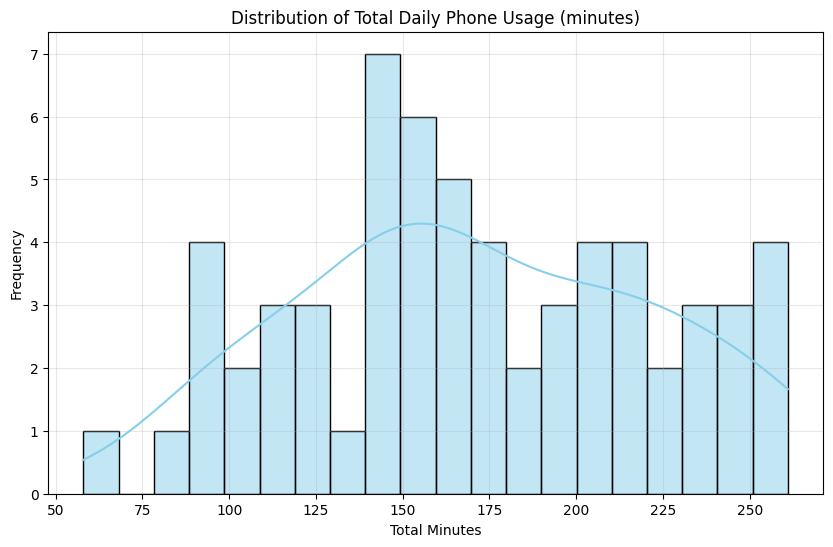

In [10]:
# Histogram of total_time_mins
plt.figure(figsize=(10,6))
sns.histplot(df['total_time_mins'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Daily Phone Usage (minutes)')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

The histogram shows a broad range of daily usage, the main peaks are between 140 and 160 minutes. There are also frequent heavy-usage days reaching up to 260 minutes. The distribution is unimodal, all data points form a continuous group and no extreme, isolated values. We can therefore confirm that there are no outliers.

Step 6: Calculate the percentage of zero values in each numeric column to identify features that may be effectively empty or inactive.

In [11]:
# Calculate count and percentage of zeros per column
zero_counts = (df[numeric_cols] == 0).sum()
zero_percent = zero_counts / len(df) * 100

# Print results
for col in numeric_cols:
    print(f"{col}: {zero_counts[col]} zeros, {zero_percent[col]:.1f}% of days")

total_time_mins: 0 zeros, 0.0% of days
insta_mins: 0 zeros, 0.0% of days
youtube_mins: 4 zeros, 6.5% of days
whatsapp_mins: 0 zeros, 0.0% of days
google_mins: 0 zeros, 0.0% of days
duolingo_mins: 55 zeros, 88.7% of days


In [12]:
# Print the duolingo_mins column
duolingo_count_non_zeros = len(df) - (df['duolingo_mins'] == 0).sum()
print("Amount of non-zero values in duolingo_mins:", duolingo_count_non_zeros)

print("duolingo_mins column values:")
print(df['duolingo_mins'])

Amount of non-zero values in duolingo_mins: 7
duolingo_mins column values:
date
2025-09-29    39
2025-09-30    38
2025-10-01    23
2025-10-02    13
2025-10-03    25
              ..
2025-11-25     0
2025-11-26     0
2025-11-27     0
2025-11-28     0
2025-11-29     0
Name: duolingo_mins, Length: 62, dtype: int64


In [13]:
df = df.drop(columns=['duolingo_mins'])
print("Columns after dropping duolingo_mins:", df.columns.tolist())

numeric_cols.remove('duolingo_mins')
app_cols = [c for c in numeric_cols if c != 'duolingo_mins']

Columns after dropping duolingo_mins: ['total_time_mins', 'insta_mins', 'youtube_mins', 'whatsapp_mins', 'google_mins']


Step 7: Create new features *day_of_week*, *month* and *is_weekend*

In [14]:
# Add day_of_week column
df['day_of_week'] = df.index.day_name()

# Add month column
df['month'] = df.index.month # 9 = September, 10 = October, 11 = November

# Add column is_weekend
df['is_weekend'] = df.index.weekday >= 5

# Display first 5 rows
print("First 5 rows:")
display(df.head())

# Display last 5 rows
print("\nLast 5 rows:")
display(df.tail())

First 5 rows:


,total_time_mins,insta_mins,youtube_mins,whatsapp_mins,google_mins,day_of_week,month,is_weekend
date,,,,,,,,
2025-09-29,155,45,39,15,5,Monday,9,False
2025-09-30,200,82,20,38,6,Tuesday,9,False
2025-10-01,171,51,16,55,10,Wednesday,10,False
2025-10-02,221,87,22,54,8,Thursday,10,False
2025-10-03,261,101,42,20,21,Friday,10,False



Last 5 rows:


,total_time_mins,insta_mins,youtube_mins,whatsapp_mins,google_mins,day_of_week,month,is_weekend
date,,,,,,,,
2025-11-25,141,46,39,24,8,Tuesday,11,False
2025-11-26,205,86,57,20,19,Wednesday,11,False
2025-11-27,142,65,34,8,24,Thursday,11,False
2025-11-28,152,67,41,18,9,Friday,11,False
2025-11-29,194,88,55,39,7,Saturday,11,True


# 5. OVERVIEW OF TOTAL USAGE

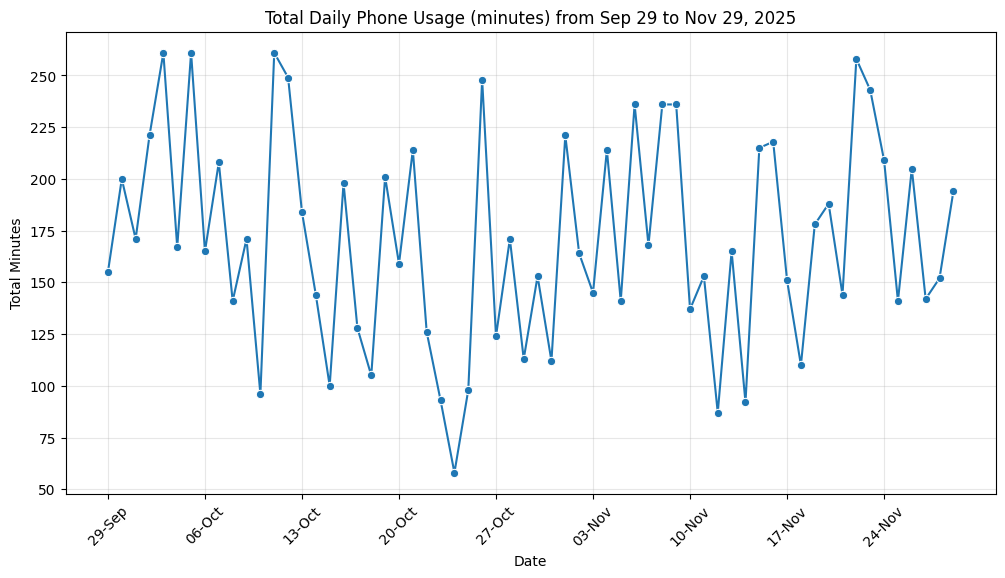

In [15]:
df_plot = df.reset_index()

# Line plot of total daily phone usage
plt.figure(figsize=(12,6))
sns.lineplot(data=df_plot, x='date', y='total_time_mins', marker='o')
plt.title('Total Daily Phone Usage (minutes) from Sep 29 to Nov 29, 2025')
plt.xlabel('Date')
plt.ylabel('Total Minutes')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Show only Mondays on the x-axis
mondays = df_plot['date'][df_plot['date'].dt.weekday == 0]  # 0 = Monday
plt.xticks(ticks=mondays, labels=[d.strftime('%d-%b') for d in mondays], rotation=45)

plt.show()

The data displays a distinct "zig-zag" pattern, which indicates that daily phone usage is variable and unstable from day to day. We can't really appreciate any clear long-term trend, as the usage oscillates  between high peaks (~260 minutes) and lower troughs. However, this continuous line plot makes it difficult to distinguish weekly cycles; it is hard to tell if specific days (such as weekends versus weekdays) are responsible for the high usage.

As a consequence of the strong day‑to‑day variability observed in the raw data, we will apply a **7‑day moving average** to smooth the series.

In [16]:
def moving_average(df, window_size):
    averages = []

    for i in range(len(df)):
      # Extract a window from the dataframe
      # Start index for the window (max to avoid negative indices)
      start = max(0, i - window_size + 1)
      end = i + 1

      window = df.iloc[start:end]
      # Compute the average
      average = window.mean(numeric_only=True)

      # Append the average to the list of averages
      averages.append(average)

    smoothed = pd.DataFrame(averages, columns=df.columns)
    smoothed.set_index(df.index, inplace=True)

    return smoothed

In [17]:
def smooth_column(df, column, window_size):
  return moving_average(df[[column]], window_size)[column]

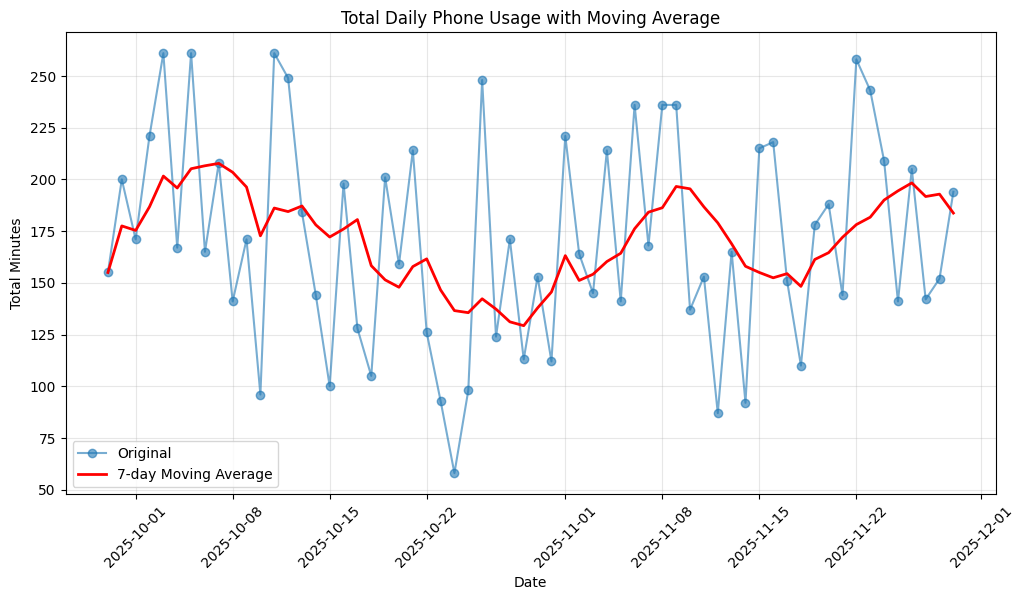

In [18]:
# Set window size
window_size = 7

# Compute smoothed series
total_smoothed = smooth_column(df, 'total_time_mins', window_size)

# Plot original vs smoothed
plt.figure(figsize=(12,6))

# Original daily usage
plt.plot(df.index, df['total_time_mins'], marker='o', alpha=0.6, label='Original')

# Smoothed series
plt.plot(total_smoothed.index, total_smoothed, color='red', linewidth=2, label=f'{window_size}-day Moving Average')

plt.title('Total Daily Phone Usage with Moving Average')
plt.xlabel('Date')
plt.ylabel('Total Minutes')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The 7-day moving average successfully reduces the noise and variability. Nevertheless, it fails to capture the real pattern of my behavior. This is because the 'zig-zag' in my data isn't just random noise to be removed, it represents the distinct weekly cycle of my life. By smoothing it out, we mask the reality of the weekend spikes and weekday drops. We flatten the data into an 'average' trend that doesn't accurately reflect my actual daily experience.

# 6. DETECT OUTLIERS

Although we initially explored outliers using a histogram during the **Data Cleaning & Preprocessing** phase, we now conduct a more detailed analysis to uncover subtle anomalies and deepen our understanding of daily usage patterns.

In [19]:
# Compute IQR and thresholds
Q1 = df['total_time_mins'].quantile(0.25)
Q3 = df['total_time_mins'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print thresholds and check if any values exceed them
print(f"Lower bound: {lower_bound:.1f}, Upper bound: {upper_bound:.1f}")
num_below = (df['total_time_mins'] < lower_bound).sum()
num_above = (df['total_time_mins'] > upper_bound).sum()
print(f"Number of days below lower bound: {num_below}")
print(f"Number of days above upper bound: {num_above}")

Lower bound: 33.4, Upper bound: 320.4
Number of days below lower bound: 0
Number of days above upper bound: 0


The IQR analysis confirms that all values fall within the defined bounds which indicates no outliers are present.

# 7. TOTAL USAGE OVER MONTHS

In [20]:
# October
october = df[df['month'] == 10]['total_time_mins']
oct_mean = october.mean()
oct_median = october.median()
print(f"October - Mean: {oct_mean:.1f}, Median: {oct_median:.1f}, Days: {len(october)}")

# November
november = df[df['month'] == 11]['total_time_mins']
nov_mean = november.mean()
nov_median = november.median()
print(f"November - Mean: {nov_mean:.1f}, Median: {nov_median:.1f}, Days: {len(november)}")

October - Mean: 164.5, Median: 165.0, Days: 31
November - Mean: 177.3, Median: 168.0, Days: 29


/tmp/ipython-input-3702604814.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['month'].isin([10,11])], x='month', y='total_time_mins', palette='Pastel1')


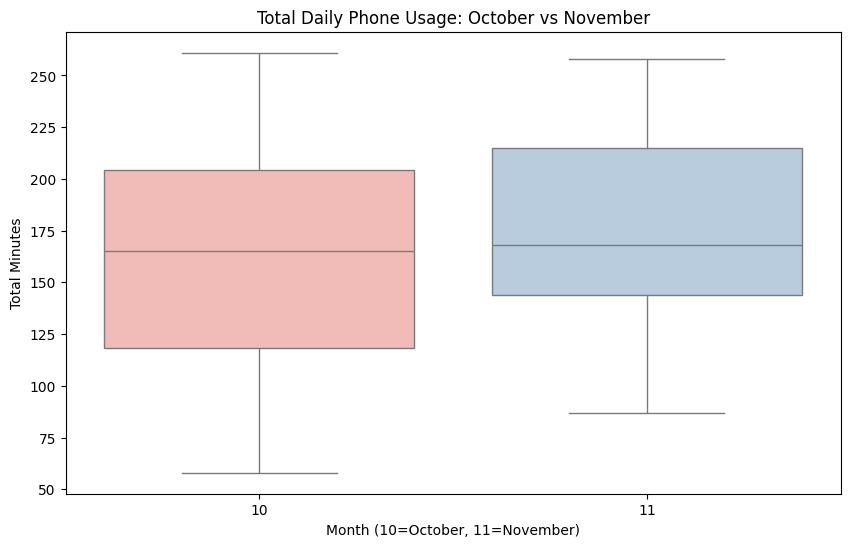

In [21]:
# Boxplot of total usage by month (October vs November)
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['month'].isin([10,11])], x='month', y='total_time_mins', palette='Pastel1')
plt.title('Total Daily Phone Usage: October vs November')
plt.ylabel('Total Minutes')
plt.xlabel('Month (10=October, 11=November)')
plt.show()

The usage is very similar between the two months. The typical day (median) is almost identical, which is 165 minutes for October and 168 minutes for November. Although November represents a slight increase on average, the box plots overlap significantly.

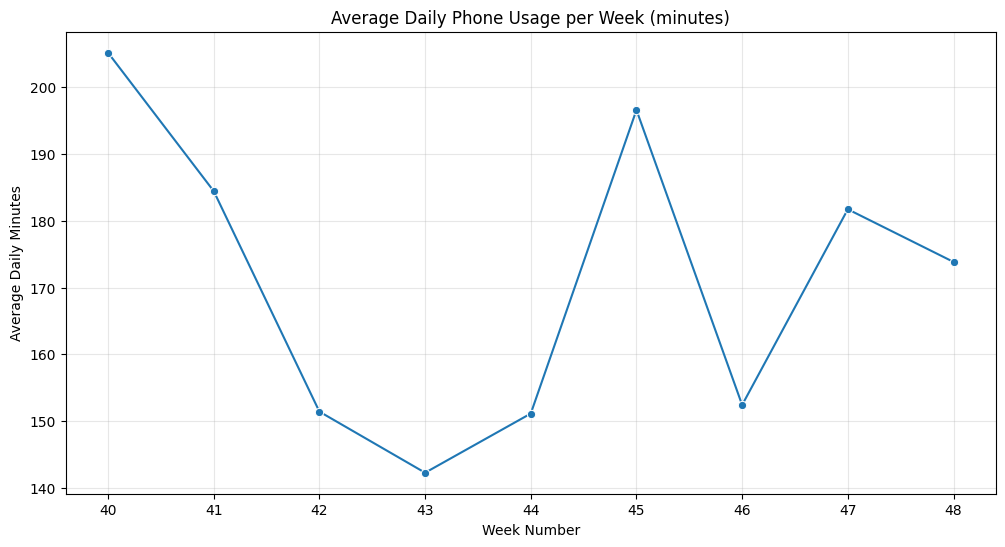

In [22]:
# Create a 'week' column using ISO week number
df['week'] = df.index.isocalendar().week

# Compute average daily usage per week
weekly_avg = df.groupby('week')['total_time_mins'].mean()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x=weekly_avg.index, y=weekly_avg.values, marker='o')
plt.title('Average Daily Phone Usage per Week (minutes)')
plt.xlabel('Week Number')
plt.ylabel('Average Daily Minutes')
plt.xticks(weekly_avg.index)
plt.grid(True, alpha=0.3)
plt.show()

Looking at the weekly trends, the pattern makes perfect sense to me and tells the story of my first few months at university. The graph starts with very high usage in weeks 40 and 41. This was right when I started classes; I wasn't very busy yet and was still feeling relaxed.

Then, we can see a big drop in weeks 42 through 44. All the homework and responsibilities piled up at once. I was busy, so I naturally spent much less time on my phone. Finally, in the last few weeks, the numbers go back up a bit. I realized I was pushing myself too hard during that stressful period, so I tried to calm down. I was still busy with school, but I found a better balance, which is why my usage leveled out again.

# 8. COMPARE WEEKDAY VS WEEKEND

In [23]:
# Weekdays
weekdays = df[df['is_weekend'] == False]['total_time_mins']
wd_mean = weekdays.mean()
wd_median = weekdays.median()
print(f"Weekdays - Mean: {wd_mean:.1f}, Median: {wd_median:.1f}, Days: {len(weekdays)}")

# Weekends
weekends = df[df['is_weekend'] == True]['total_time_mins']
we_mean = weekends.mean()
we_median = weekends.median()
print(f"Weekends - Mean: {we_mean:.1f}, Median: {we_median:.1f}, Days: {len(weekends)}")

Weekdays - Mean: 156.1, Median: 153.0, Days: 45
Weekends - Mean: 210.3, Median: 221.0, Days: 17


/tmp/ipython-input-2944982574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['is_weekend'], y=df['total_time_mins'], palette=['lightblue', 'lightgreen'])


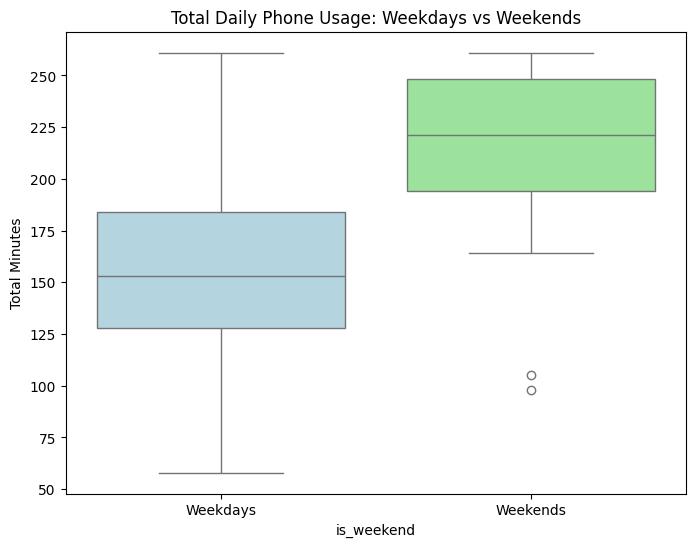

In [24]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['is_weekend'], y=df['total_time_mins'], palette=['lightblue', 'lightgreen'])
plt.xticks([0,1], ['Weekdays', 'Weekends'])
plt.title('Total Daily Phone Usage: Weekdays vs Weekends')
plt.ylabel('Total Minutes')
plt.show()

As expected, the data confirms that I am much more active on my phone during the weekends compared to weekdays. On weekdays, my average usage is around 156 minutes, which reflects my busy schedule with classes, homework and other activities.

On weekends, however, that average jumps significantly to 210 minutes, almost an hour more per day. You can clearly see this in the plot, where the green box sits much higher than the blue one. Interestingly, two clear outliers appear in the data, both representing extreme values. It is reasonable to suspect that these points were generated by a different mechanism. They correspond to two weekend days in which I did not use my mobile phone due to attending an important event.

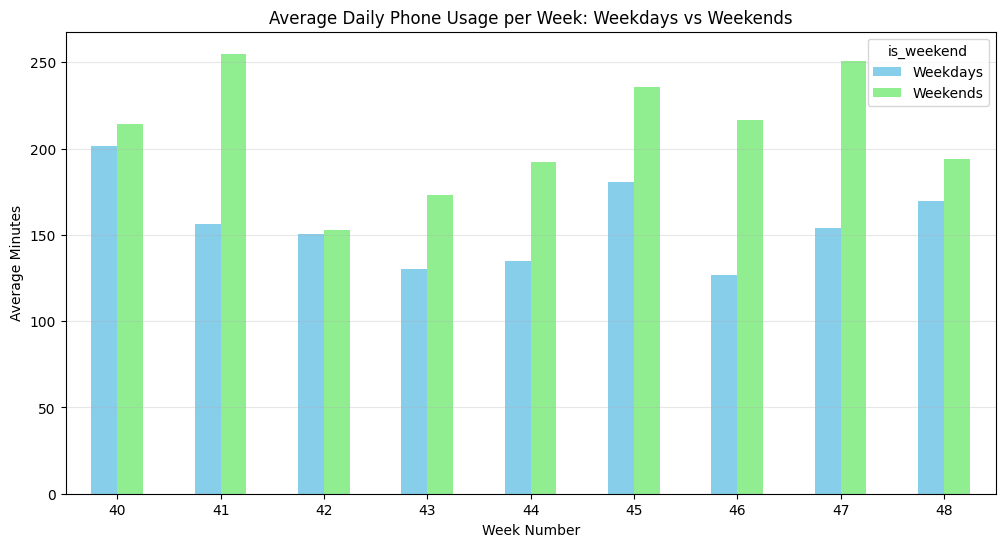

In [25]:
# Group by week and is_weekend, compute mean daily usage
weekly_usage = df.groupby(['week', 'is_weekend'])['total_time_mins'].mean().unstack()
weekly_usage.rename(columns={False:'Weekdays', True:'Weekends'}, inplace=True)

# Plot
weekly_usage.plot(kind='bar', figsize=(12,6), color=['skyblue', 'lightgreen'])
plt.title('Average Daily Phone Usage per Week: Weekdays vs Weekends')
plt.ylabel('Average Minutes')
plt.xlabel('Week Number')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

The previous boxplot showed that weekends are higher on average, but that could have been misleading if just one extreme weekend had skewed the data. This chart proves that is not the case.

Since the green bar is taller than the blue bar in every individual week, we can see that this isn't just a statistical average, instead it is a repeated behavior. The pattern holds true for all the analyzed weeks.

# 9. USAGE BY DAY OF THE WEEK

In [26]:
# Group by day_of_week and compute average total usage
weekday_avg = df.groupby('day_of_week')['total_time_mins'].mean()

# Sort days in calendar order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = weekday_avg.reindex(days_order)

print("Average total daily usage by day of the week:")
for day, val in weekday_avg.items():
    print(f"{day}: {val:.1f} minutes")

Average total daily usage by day of the week:
Monday: 158.8 minutes
Tuesday: 172.8 minutes
Wednesday: 140.2 minutes
Thursday: 174.1 minutes
Friday: 134.6 minutes
Saturday: 195.0 minutes
Sunday: 227.5 minutes


/tmp/ipython-input-2528319875.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='Pastel2')


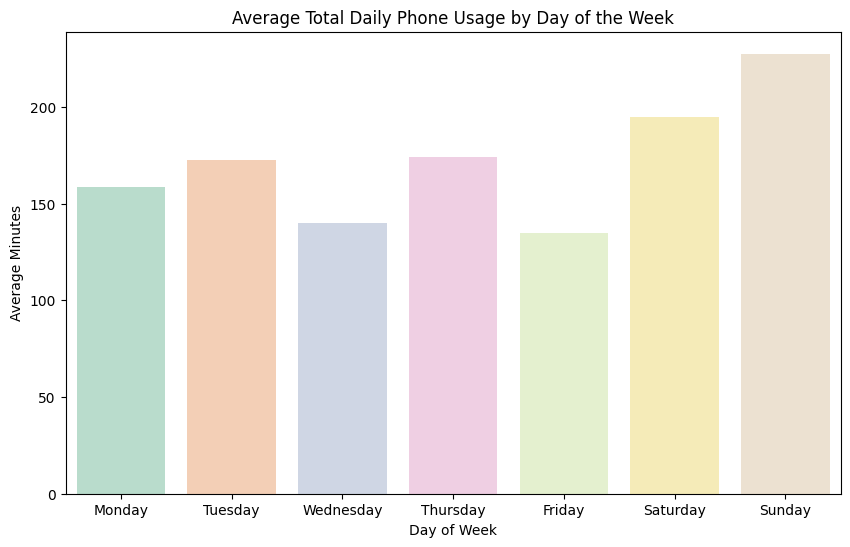

In [27]:
# Bar plot of total usage per day of week
plt.figure(figsize=(10,6))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='Pastel2')
plt.title('Average Total Daily Phone Usage by Day of the Week')
plt.ylabel('Average Minutes')
plt.xlabel('Day of Week')
plt.show()

This breakdown confirms again that weekends are my highest usage days, with Sunday being the peak at over 227 minutes.

On weekdays, the "up and down" pattern matches my sports schedule. My usage drops noticeably on Mondays, Wednesdays, and Fridays, which coincides with the days of the week in which I usually practice sport (Monday and Friday). Therefore, it might be the reason why my phone usage is lower.

# 10. USAGE OF EACH APP

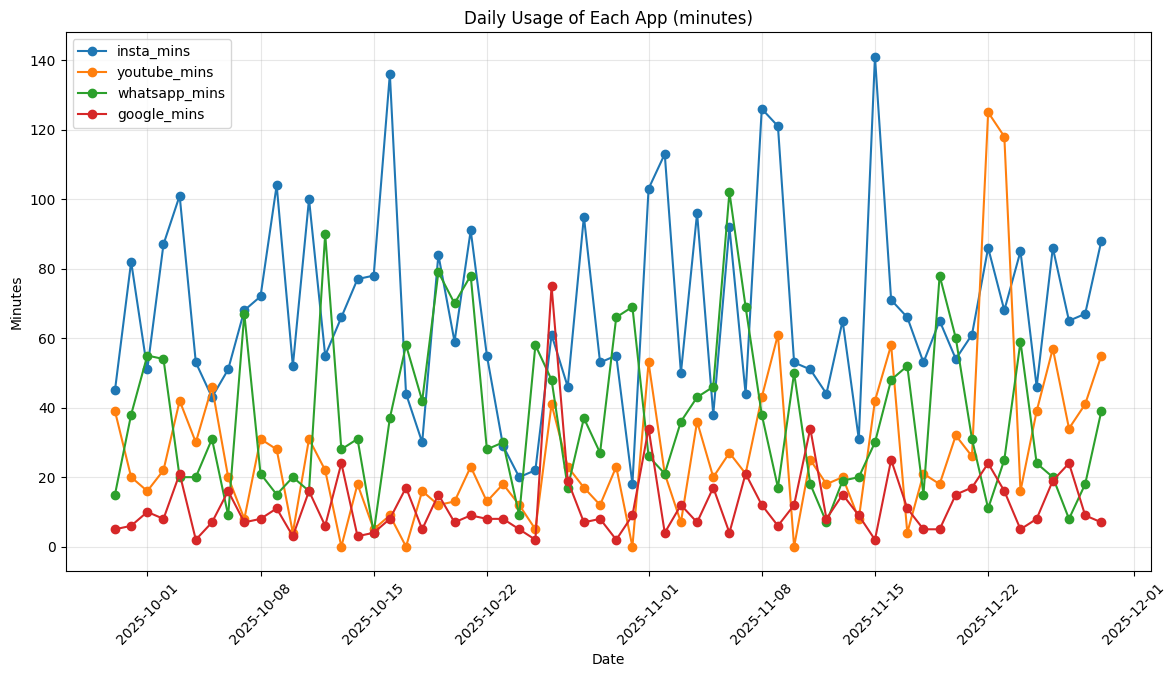

In [28]:
# Daily usage per app
apps = ['insta_mins', 'youtube_mins', 'whatsapp_mins', 'google_mins']

plt.figure(figsize=(14,7))
for app in apps:
    plt.plot(df.index, df[app], marker='o', label=app)

plt.title('Daily Usage of Each App (minutes)')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Even though the graph looks messy with all the daily zig-zags, the ranking of my apps is actually quite clear. Instagram (the blue line) is at the top, which proves it is my main app for entertainment regardless of the day.

Below that, WhatsApp and YouTube usually compete for second place in the middle range. Google (the red line) stays flat at the bottom, which makes sense because I only use it for quick searches, not for long sessions of scrolling like I do on social media.

In [29]:
# Total usage of each app through the 2 months
print(df[apps].sum().head())

insta_mins       4212
youtube_mins     1665
whatsapp_mins    2317
google_mins       748
dtype: int64


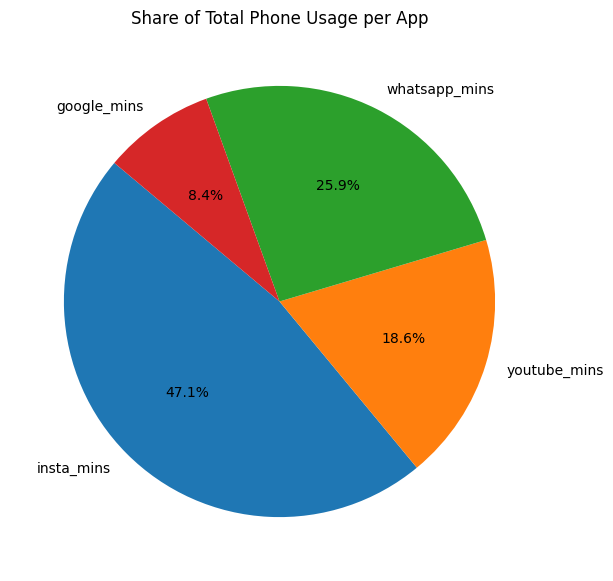

In [30]:
# Pie Chart of App Usage

total_usage = df[apps].sum()

plt.figure(figsize=(7,7))
plt.pie(total_usage, labels=total_usage.index, autopct='%1.1f%%', startangle=140)
plt.title("Share of Total Phone Usage per App")
plt.show()


This pie chart confirms what we saw in the messy line graph, but makes it much simpler to understand the general pattern.

Instagram is definitely the most used app. It takes up almost half (47.1%) of my total phone time. WhatsApp comes in second with about a quarter of the time (25.9%), followed by YouTube at 18.6%. Google is just a small slice (8.4%).

# 11. APP USAGE BY DAY OF THE WEEK

In [31]:
weekly_app_usage = df.groupby('day_of_week')[apps].mean()

# Reorder rows to proper weekday sequence
weekly_app_usage = weekly_app_usage.reindex(days_order)

print(weekly_app_usage)

             insta_mins  youtube_mins  whatsapp_mins  google_mins
day_of_week                                                      
Monday        57.888889     13.555556      37.333333    12.333333
Tuesday       73.222222     23.000000      39.000000     9.555556
Wednesday     60.222222     21.111111      31.777778     9.666667
Thursday      76.333333     23.666667      43.444444    10.555556
Friday        48.666667     17.111111      34.888889    12.333333
Saturday      83.222222     44.444444      31.111111    11.555556
Sunday        77.000000     47.375000      44.875000    19.250000


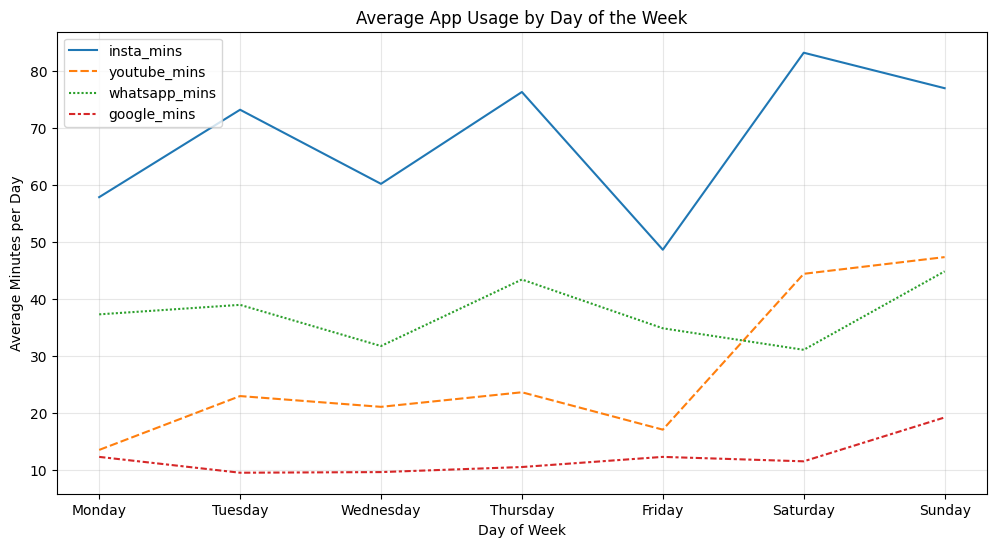

In [32]:
# Barplot of the app usage by weekday
plt.figure(figsize=(12,6))
sns.lineplot(data=weekly_app_usage)
plt.title("Average App Usage by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Minutes per Day")
plt.grid(True, alpha=0.3)
plt.show()

It can be observed in the plot that my phone usage across different applications rises noticeably on weekends. This trend is especially clear for Instagram and YouTube, where usage reaches its peak during those days. For WhatsApp, the weekend effect is less pronounced, as the app follows its weekday pattern. Meanwhile, Google shows minimal variation, since I only use it for a few minutes each day.

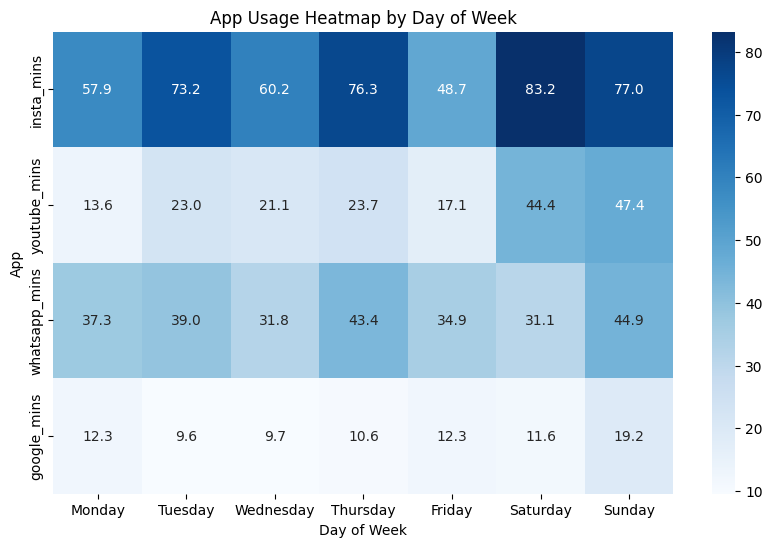

In [33]:
# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(weekly_app_usage.T, annot=True, fmt=".1f", cmap="Blues")
plt.title("App Usage Heatmap by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("App")
plt.show()

Instagram dominates my usage during all days of the week. The top row is entirely blue, which confirms that it is the most used app every single day. Even on my busiest days, such as Mondays and Fridays, I still dedicate nearly an hour to it. Usage peaks on Saturday at 83.2 minutes.

YouTube is very light during the week (mostly under 20 minutes), but it suddenly turns dark blue on the weekends, jumping to 44–47 minutes. Hence, I tend to spend more time watching youtube on weekends.

The Friday column appears to be the lightest overall, which aligns with my routine. As I already mentioned, I typically practice sports on that day and also attend university, which leaves less time for phone usage.

# 12. OCTOBER VS NOVEMBER FOR EACH APP

In [34]:
# Compute October and November means for each app
oct_means = df[df['month'] == 10][apps].mean()
nov_means = df[df['month'] == 11][apps].mean()

print("Average daily usage per app (October):")
print(oct_means.round(2))
print("\nAverage daily usage per app (November):")
print(nov_means.round(2))

Average daily usage per app (October):
insta_mins       63.10
youtube_mins     18.06
whatsapp_mins    39.81
google_mins      11.29
dtype: float64

Average daily usage per app (November):
insta_mins       73.41
youtube_mins     36.07
whatsapp_mins    35.52
google_mins      13.34
dtype: float64


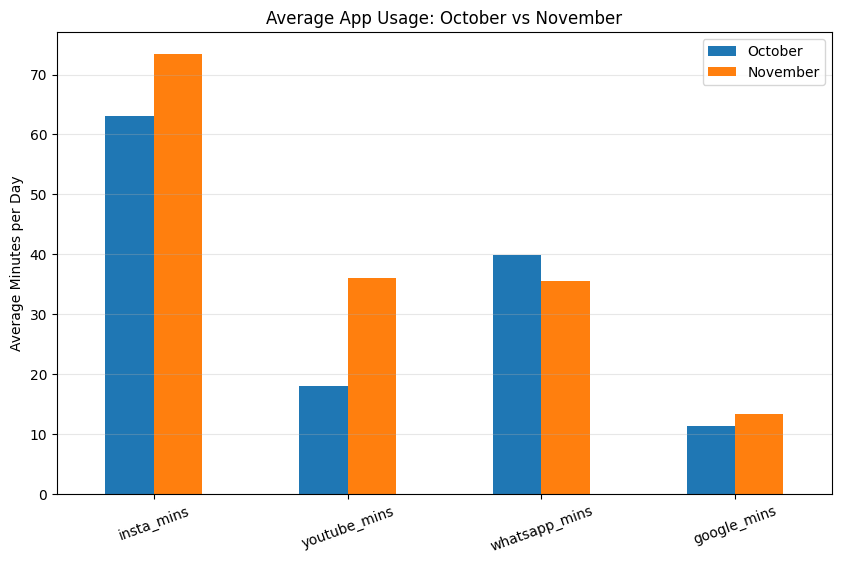

In [35]:
# Plot: grouped bar chart
comparison_df = pd.DataFrame({
    'October': oct_means,
    'November': nov_means
})

comparison_df.plot(kind='bar', figsize=(10,6), rot=20)
plt.ylabel('Average Minutes per Day')
plt.title('Average App Usage: October vs November')
plt.grid(axis='y', alpha=0.3)
plt.show()

From October to November, my Instagram usage went up slightly, while YouTube nearly doubled, which was unexpected. On the other hand, WhatsApp and Google remained almost the same.

# 13. CORRELATION BETWEEN APP USAGES

In [36]:
# Correlation matrix (apps + total_time_mins)
# Use Pearson Correlation
corr = df[numeric_cols].corr()

print("Correlation matrix:")
print(corr)

Correlation matrix:
                 total_time_mins  insta_mins  youtube_mins  whatsapp_mins  \
total_time_mins         1.000000    0.638661      0.573168       0.252004   
insta_mins              0.638661    1.000000      0.325311      -0.050053   
youtube_mins            0.573168    0.325311      1.000000      -0.262012   
whatsapp_mins           0.252004   -0.050053     -0.262012       1.000000   
google_mins             0.301277   -0.004268      0.267348      -0.081139   

                 google_mins  
total_time_mins     0.301277  
insta_mins         -0.004268  
youtube_mins        0.267348  
whatsapp_mins      -0.081139  
google_mins         1.000000  


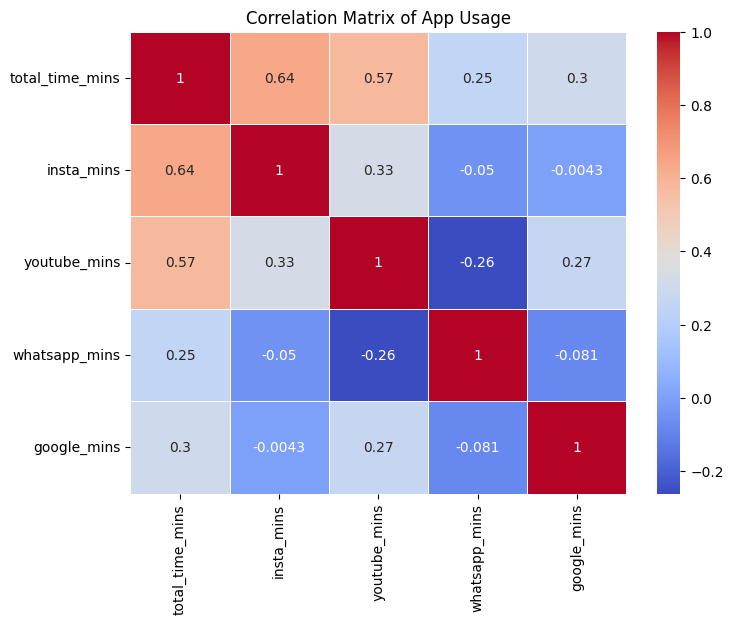

In [37]:
# Heatmap of the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of App Usage")
plt.show()

As expected, all apps contribute to my total screen time, but Instagram and YouTube stand out as the most influential. Their strong positive correlation indicates that high daily usage is usually driven by these two platforms.

Looking at relationships among the apps themselves, three patterns emerge. First, Instagram and YouTube are significantly correlated, which means that when I use one, I am likely to use the other as well. Second, YouTube and WhatsApp show a negative correlation. This suggests that heavy use of one coincides with lighter use of the other. Finally, Google appears completely uncorrelated with the social apps (Instagram and WhatsApp). Such behaviour reinforces the idea that I treat Google as a utility tool used independently of whether I am having a heavy or light phone day.

# 14. AUTOCORRELATIONS

To mathematically verify the patterns I saw earlier, we use an algorithm to calculate the Autocorrelation of the dataset. This measures how strongly my phone usage today is linked to my usage in the past.

In [38]:
def correlation_without_nan(x, y):
    # Calculates Pearson correlation between two lists
    if len(x) < 2: return 0
    return np.corrcoef(x, y)[0, 1]

In [39]:
def lagged_series(series, lag):
    original_trimmed = []  # Part of the original series that has a valid lag
    lagged = [] # Series shifted by lag periods

    for i in range(len(series)):
        j = i - lag
        if 0 <= j < len(series):
            original_trimmed.append(series[i])
            lagged.append(series[j])

    return original_trimmed, lagged

In [40]:
def autocorrelation(series, lag):
    x, y = lagged_series(series, lag)
    return correlation_without_nan(x, y)

In [41]:
def compute_autocorrelations(series, max_periods):
    autocorrs = []
    for lag in range(max_periods):
        corr = autocorrelation(series, lag)
        autocorrs.append(corr)
    return autocorrs

In [42]:
def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    plt.figure(figsize=(10, 5))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o', linewidth=2)

    # Add horizontal line at zero
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)

    # We set ticks to 7 to highlight the weekly cycle
    ticks = np.arange(0, len(correlations), 7)
    labels = [f"{t} (Week {t//7})" if t > 0 else "0" for t in ticks]
    plt.xticks(ticks, labels, rotation=45)

    plt.title("Autocorrelation of Phone Usage")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()

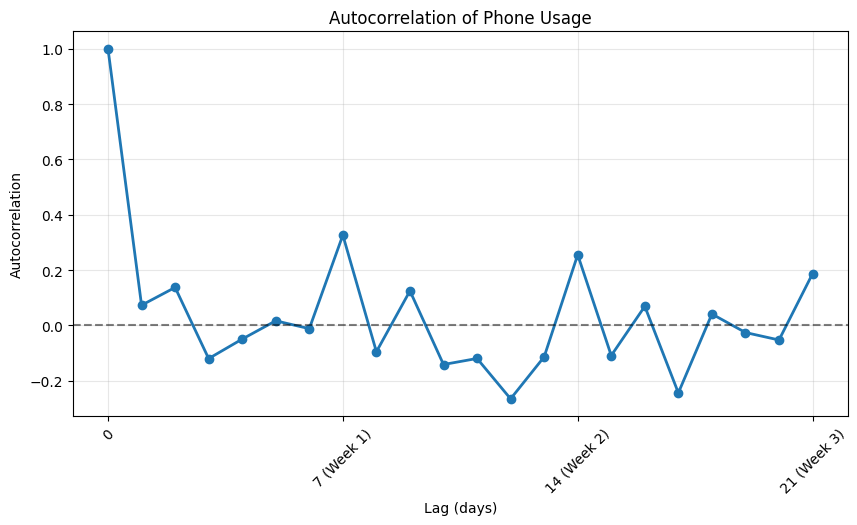

In [43]:
# Get the data list
data_series = df['total_time_mins'].tolist()

# Compute for 22 days (3 weeks)
corrs = compute_autocorrelations(data_series, max_periods=22)

# Plot
plot_auto_correlations(corrs)

The autocorrelation plot suggests that my phone usage follows a 7-day cycle. The clear spikes at Lag 7, 14, and 21 prove that my habits repeat exactly every week. This means that my usage today is similar to my usage exactly one, two, or three weeks ago. In contrast, for the lags not divisible by 7, the correlation drops significantly. This happens because the model is comparing "mismatched" days

# 15. CATEGORIZE USAGE INTO BINS: EQUI-WIDTH (SAME INTERVAL SIZE)

In [44]:
col = df['total_time_mins']
k = 3 # number of categories (labels)

# Get min and max values
data_min = col.min()
data_max = col.max()

# Compute the range
value_range = data_max - data_min
bin_width = value_range / k

# Compute bin edges
edges = [data_min + i*bin_width for i in range(k+1)]
edges = [round(edge, 2) for edge in edges]   # round each value

# Build intervals
intervals = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print("Equi-width intervals:")
for i, interval in enumerate(intervals, start=1):
    print(f"Bin {i}: [{interval[0]}, {interval[1]}]")

Equi-width intervals:
Bin 1: [58.0, 125.67]
Bin 2: [125.67, 193.33]
Bin 3: [193.33, 261.0]


In [45]:
# Create empty list to store bin labels
# Each element will be in "Bin 1", "Bin 2", or "Bin 3"
equiwidth_bin_manual = []

# Loop through each value
for value in df['total_time_mins']:
    bin_label = None
    # Loop through all the intervals computed earlier
    for i, (low, high) in enumerate(intervals, start=1):
      # For all bins except the last, check if the value falls in the interval
      if i < k:
          if low <= value < high:
              bin_label = f"Bin {i}"
              break
      else:  # last bin includes upper bound
          if low <= value <= high:
              bin_label = f"Bin {i}"
              break
    equiwidth_bin_manual.append(bin_label)

In [46]:
# Assign to dataframe
df['equiwidth_bin_manual'] = equiwidth_bin_manual

# Check first rows
print(df[['total_time_mins', 'equiwidth_bin_manual']].head())

# Count of days per bin
print("\nNumber of days in each bin:")
print(df['equiwidth_bin_manual'].value_counts().sort_index())

            total_time_mins equiwidth_bin_manual
date                                            
2025-09-29              155                Bin 2
2025-09-30              200                Bin 3
2025-10-01              171                Bin 2
2025-10-02              221                Bin 3
2025-10-03              261                Bin 3

Number of days in each bin:
equiwidth_bin_manual
Bin 1    12
Bin 2    27
Bin 3    23
Name: count, dtype: int64


Count how many days in each bin are weekdays vs weekends

In [47]:
# Initialize a dictionary to store counts
bin_counts = {}

# Loop through each bin
for bin_label in df['equiwidth_bin_manual'].unique():
    # Filter rows in this bin
    bin_df = df[df['equiwidth_bin_manual'] == bin_label]

    # Count weekdays and weekends
    weekdays_count = (bin_df['is_weekend'] == False).sum()
    weekends_count = (bin_df['is_weekend'] == True).sum()

    # Store in dictionary
    bin_counts[bin_label] = {'Weekdays': weekdays_count, 'Weekends': weekends_count}

# Print results
print("Number of weekdays and weekends in each equi-width bin:\n")
for bin_label, counts in sorted(bin_counts.items()):
    print(f"{bin_label}: Weekdays = {counts['Weekdays']}, Weekends = {counts['Weekends']}")

Number of weekdays and weekends in each equi-width bin:

Bin 1: Weekdays = 10, Weekends = 2
Bin 2: Weekdays = 25, Weekends = 2
Bin 3: Weekdays = 10, Weekends = 13


By grouping the data into three "usage levels": Low (Bin 1), Medium (Bin 2), and High (Bin 3), we can see a clear split in my habits.

First, the Low usage group is the smallest (only 12 days), which shows it is relatively rare for me to stay off my phone. Most of my days fall into the Medium range (27 days), which is dominated almost entirely by weekdays.

The most telling part is the High usage group (Bin 3). This is the only category where weekends outnumber weekdays (13 weekends vs. 10 weekdays).

# 16. STATISTICS TEST

We consider that we have two groups: **Weekdays vs Weekends**.
Each group has a multivariate mean vector of 4 variables:

*insta_mins, youtube_mins, whatsapp_mins, google_mins*

We want to test whether the mean usage of these apps differs depending on the type of the day. Therefore, we will use **Hotelling’s T²** for comparing two multivariate means.

We assume the following conditions hold:
- Multivariate Normality: The data is assumed to follow a multivariate normal distribution.

- Equal Covariance Matrices: Both groups are assumed to have similar covariance structures.

- Independence of observatons Days are approximately independent


Let *μ_wd* and *μ_we* be the 4-dimensional population mean vectors for Weekdays and Weekends, correspondingly.

That said, the hypotheses can be stated properly:

Null hypothesis (No difference): $H_0: \mu_{wd} = \mu_{we}$

Alternative hypothesis (Significant difference): $H_1: \mu_{wd} \neq \mu_{we}$

Therefore, we will proceed to test at significance level α = 0.05


**Note: Since our data represents consecutive days from a single subject, the assumption of independence is strictly violated due to time-series autocorrelation. However, we proceed with the test for exploratory purposes to assess the statistical significance of the behavioral shift observed in our boxplots.**

In [48]:
# Create the two groups based on Day of Week
df_wd = df[df['is_weekend'] == 0][apps]
df_we = df[df['is_weekend'] == 1][apps]

n1 = len(df_wd) # number of weeday samples
n2 = len(df_we) # number of weekend samples
p = len(apps) # number of predictor variables (apps)

# Mean vectors (p × 1) for weekday and weekend samples
# For each group compute the mean of each column (each app)
mean1 = df_wd.mean().values.reshape(p, 1)
mean2 = df_we.mean().values.reshape(p, 1)

# Covariance matrices
S1 = np.cov(df_wd.T, bias=False)
S2 = np.cov(df_we.T, bias=False)

# Pooled covariance matrix
Sp = ((n1 - 1) * S1 + (n2 - 1) * S2) / (n1 + n2 - 2)

In [49]:
# Compute Hotelling's T^2 statistic
d = mean1 - mean2  # difference in means (column vector)

T2 = (n1 * n2) / (n1 + n2) * d.T @ np.linalg.inv(Sp) @ d
T2 = float(T2)  # extract scalar

/tmp/ipython-input-2575080825.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T2 = float(T2)  # extract scalar


In [50]:
# Critical Value Calculation
alpha = 0.05
df1 = p
df2 = n1 + n2 - p - 1

# F critical value
F_crit = f.ppf(1 - alpha, df1, df2)

# Convert F-crit to T2-crit
T_crit = ((n1 + n2 - 2) * p / (n1 + n2 - p - 1)) * F_crit

In [51]:
# Output Results
print(f"Weekdays (n={n1}) vs Weekends (n={n2})")
print(f"T2 Statistic: {T2:.2f}")
print(f"Critical Value (T_crit): {T_crit:.2f}")
print("-" * 30)

Weekdays (n=45) vs Weekends (n=17)
T2 Statistic: 24.73
Critical Value (T_crit): 10.67
------------------------------


In [52]:
if T2 > T_crit:
    print("Result: Reject H0.")
    print("Conclusion: There is a statistically significant difference in app usage patterns between Weekdays and Weekends.")
else:
    print("Result: Fail to reject H0.")
    print("Conclusion: No significant multivariate difference found.")

Result: Reject H0.
Conclusion: There is a statistically significant difference in app usage patterns between Weekdays and Weekends.


Therefore, there significant evidence to reject H0 at significance level α = 0.05. We conclude that we reject the null hypothesis: there is a significant multivariate difference in app usage between Weekdays and Weekends.

# 17. MACHINE LEARNING: LOGISTIC REGRESSION

To complement our statistical analysis, we apply a supervised machine learning approach using logistic regression. The goal is to predict whether a given day is a weekday or weekend based on the minutes spent on Instagram, YouTube, WhatsApp, and Google.

In [53]:
# Prepare the Data
# Features (X): The minutes spent on each app
X = df[apps]

# Target (y): 1 if Weekend (Sat/Sun), 0 if Weekday
y = df['is_weekend']

In [54]:
# Splits the dataset into training (80%) and testing (20%) sets
# We shuffle the data to break the "time series" order for this specific classification task
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Scale the data (apps have different ranges of minutes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [55]:
# Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Weekday', 'Weekend']))

Model Accuracy: 76.92%

Classification Report:
              precision    recall  f1-score   support

     Weekday       0.75      1.00      0.86         9
     Weekend       1.00      0.25      0.40         4

    accuracy                           0.77        13
   macro avg       0.88      0.62      0.63        13
weighted avg       0.83      0.77      0.72        13



The model reached about 77% accuracy, which means it correctly classified most of the days. It was perfect at recognizing weekdays because it catched all of them without mistakes (recall = 1.00). However, the model struggled with weekends as it correctly identified only the most obvious ones (recall = 0.25). Interestingly, whenever it did guess a weekend or a weekday, it was almost always right (precisions of 0.75 and 1.00).

This likely happened because the dataset contains far more weekdays than weekends, so the weekend group is underrepresented. In addition, the overall dataset size is small.

In [56]:
# Extract the learned coefficients from the logistic regression model
importance = pd.DataFrame({
    'App': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (Higher means more 'Weekend-like'):")
print(importance)


Feature Importance (Higher means more 'Weekend-like'):
             App  Coefficient
1   youtube_mins     1.265845
2  whatsapp_mins     0.366429
3    google_mins     0.155608
0     insta_mins     0.112131


Each coefficient shows how much that feature (app minutes) contributes to predicting the target (weekend vs weekday).

Positive coefficient → higher values of that feature push the prediction toward weekend (class = 1).

Negative coefficient → higher values would push the prediction toward weekday (class = 0).

/tmp/ipython-input-692681851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Coefficient', y='App', palette='coolwarm')


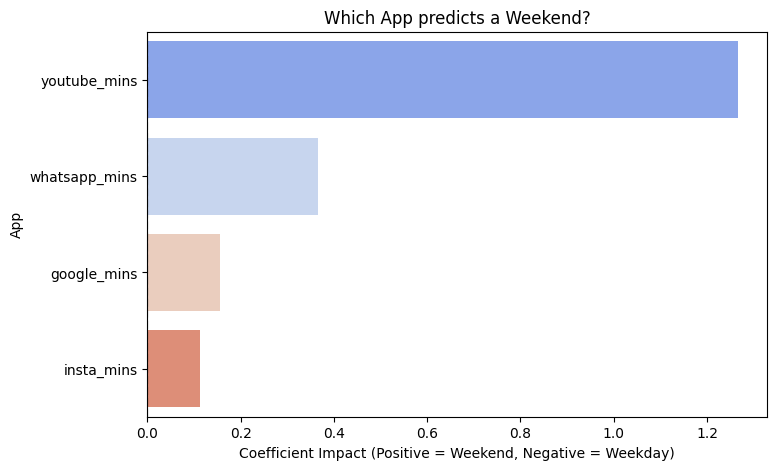

In [57]:
# Visualization of Importance
plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Coefficient', y='App', palette='coolwarm')
plt.title('Which App predicts a Weekend?')
plt.xlabel('Coefficient Impact (Positive = Weekend, Negative = Weekday)')
plt.axvline(0, color='black', linestyle='--')
plt.show()

The logistic regression reveals an important characteristic about my phone usage habits:

All coefficients are positive, which means that an increase in usage on any app makes it more likely to be a weekend. This confirms that I don't have a specific "weekday app" that I stop using in the weekend. Instead, as we discovered earlier, my weekends are defined by a general increase in screen time.

However, the magnitude of the coefficients provides insightful information. YouTube usage is the strongest indicator of weekend. A higher number of minutes spent on YouTube strongly increases the likelihood that a day is classified as Saturday or Sunday. WhatsApp, Google, and Instagram also show positive associations with weekends, but their coefficients are much smaller. Therefore, although they contribute to the prediction, their influence is much weaker.


# 18. CONCLUSIONS

This project allowed me to implement a range of algorithms, data visualization methods, and data mining techniques to uncover meaningful insights from the dataset. It was a rewarding way to apply the knowledge gained in Data Mining and see it come to life in practice. The analysis revealed several interesting patterns, such as higher overall mobile usage on weekends, increased activity on apps like Instagram, and distinct usage trends across different days of the week. Some of these findings were unexpected at first but became logical once explored, highlighting the value of combining technical tools with thoughtful analysis.

# 19. ACKNOWLEDGEMENTS

I would like to thank Prof. Carlos “ChaTo” Castillo for his dedication to teaching, which inspired me to pursue this project. His ability to transmit motivation encouraged me to explore the subject deeply and apply several advanced algorithms and data mining techniques

